In [464]:
# %pip install pyyaml opencv-python matplotlib numpy scipy -i https://pypi.tuna.tsinghua.edu.cn/simple

# 模板处理

In [465]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import least_squares
import yaml
import os

## 参数读入

In [466]:
# 数据集：
# 'source/1.1'
# 'source/1.2' 不推荐使用 没有正常的模板
# 'source/1.3'

source_path = 'source/1.1'
config_file_path = os.path.join(source_path, 'config.yaml')


数据集格式：
```plain
source/dataset/
- img/ # 待测图片
    - xxx1.jpg
    - xxx2.jpg
    - ...
- template.jpg # 模板图
- config.yaml # 参数

```

In [467]:

def load_specific_config(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        config = yaml.safe_load(file)

    # 提取特定配置项
    image_path = config.get('image', {}).get('path')
    candidate_points = config.get('candidate_points', [])
    zone_point = config.get('scan_zone', {}).get('center_point', [0, 0])
    zone_radius = config.get('scan_zone', {}).get('radius', 0)
    zone_theta = config.get('scan_zone', {}).get('angle', 0)
    valid_threshold = config.get('scan_zone', {}).get('valid_threshold', 0)
    step = config.get('scale', {}).get('step', 5)
    start_point = config.get('scale', {}).get('start', 0.0)
    end_point = config.get('scale', {}).get('end', 0.0)
    precision = config.get('scale', {}).get('precision', 0)
    unit = config.get('scale', {}).get('unit', '')

    return (
        image_path,
        candidate_points,
        zone_point,
        zone_radius,
        zone_theta,
        valid_threshold,
        step,
        start_point,
        end_point,
        precision,
        unit
    )

(
    image_path,
    candidate_point,
    zone_point,
    zone_radius,
    zone_theta,
    valid_threshold,
    step,
    START_POINT,
    END_POINT,
    PRESICISION,
    UNIT
) = load_specific_config(config_file_path)

# 打印提取的配置项以检查是否正确加载
print(f"Image Path: {image_path}")
print(f"Candidate Points: {candidate_point}\n")
print(f"Zone Point: {zone_point}")
print(f"Zone Radius: {zone_radius}")
print(f"Zone Theta: {zone_theta}")
print(f"Valid Threshold: {valid_threshold}")
print(f"step {step}")
print(f"Start Point: {START_POINT}\nEnd Point: {END_POINT}")
print(f"Precision: {PRESICISION}\nUnit: {UNIT}")

Image Path: source/1.1/template2.jpg
Candidate Points: [[700, 766], [624, 659], [603, 528], [647, 403], [745, 311], [851, 276], [981, 292], [1086, 361], [1152, 472], [1160, 601], [1107, 720]]

Zone Point: [970, 362]
Zone Radius: 20
Zone Theta: 10
Valid Threshold: 70
step 5
Start Point: -0.1
End Point: 0.9
Precision: 2
Unit: MPa


debug用的函数

In [468]:
# 展示图片
def show_img(image):
    # OpenCV 读取的图像是 BGR 格式，而 Matplotlib 显示的是 RGB 格式
    # 因此需要将图像从 BGR 转换为 RGB
    if image is None: print("Error: Unable to load image.")
    else:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # 使用 Matplotlib 显示图像
        plt.figure(figsize=(12, 12))
        plt.imshow(image_rgb)
        plt.axis('off')  # 关闭坐标轴
        plt.show()

# 绘制点集在图片上 （reversed控制图片坐标系或真实坐标系）
def show_point(image, x_point, y_point, color = (0, 255, 255), reversed=True):
    image_temp = image.copy()
    for (x, y) in zip(x_point, y_point):
        if reversed: cv2.circle(image_temp, (int(x), int(image.shape[1] - y)), 4, color, -1)
        else: cv2.circle(image_temp, (int(x), int(y)), 4, color, -1)
    show_img(image_temp)

模板图片需要尽量正面

如果质量不好，建议直接将非表盘必要的内容进行屏蔽（PhotoShop）操作一下

In [469]:
# 模板读取
image = cv2.imread(image_path)
candidate_point = np.array(candidate_point)

(1080, 1920, 3)


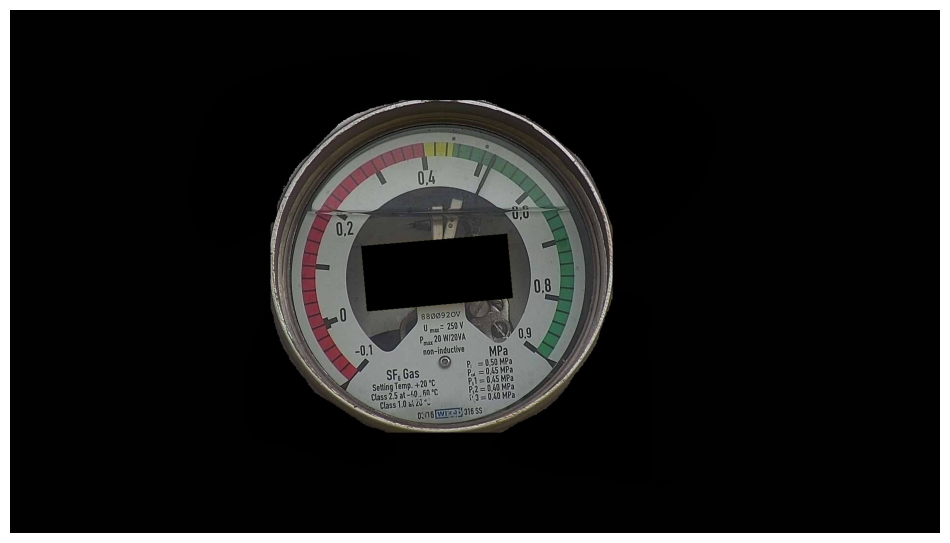

In [470]:
# debug
print(image.shape)
show_img(image)

## 椭圆拟合

In [471]:
from scipy.optimize import least_squares
import numpy as np

def my_fun(parameters, x_samples, y_samples):
    # Unpack parameters: two focus points and the target distance sum
    x_focus_1, y_focus_1, x_focus_2, y_focus_2, sum_of_target_distance = parameters

    # Calculate the actual distances from the points to the two foci
    distance_to_focus_1 = np.sqrt((x_samples - x_focus_1) ** 2 + (y_samples - y_focus_1) ** 2)
    distance_to_focus_2 = np.sqrt((x_samples - x_focus_2) ** 2 + (y_samples - y_focus_2) ** 2)

    # Return the difference between actual and target distances for each point
    return distance_to_focus_1 + distance_to_focus_2 - sum_of_target_distance

def fit_ellipse(x_samples, y_samples):

    # Compute the centroid of the samples
    centroid_x = np.mean(x_samples)
    centroid_y = np.mean(y_samples)

    # Find the point farthest from the centroid
    distances_from_centroid = np.sqrt((x_samples - centroid_x) ** 2 + (y_samples - centroid_y) ** 2)
    max_distance_index = np.argmax(distances_from_centroid)
    far_point_x = x_samples[max_distance_index]
    far_point_y = y_samples[max_distance_index]

    # Initial guess for the second focus
    x_focus_2_init = far_point_x
    y_focus_2_init = far_point_y

    # Estimate the sum of distances from any point on the ellipse to the foci
    sum_of_target_distance_init = 2 * distances_from_centroid[max_distance_index]

    # Optimize to fit the ellipse using initial guesses for the parameters
    initial_guess = np.array([centroid_x, centroid_y, x_focus_2_init, y_focus_2_init, sum_of_target_distance_init])
    res_optimized = least_squares(fun=my_fun, x0=initial_guess, args=(x_samples, y_samples))

    if res_optimized.success:
        # Unpack optimized parameters
        x1_res, y1_res, x2_res, y2_res, l2_res = res_optimized.x

        # Calculate the angle of the ellipse based on the foci
        alpha_res = np.arctan2(y2_res - y1_res, x2_res - x1_res)

        # Calculate the distance between the foci
        l_ab = np.sqrt((y2_res - y1_res) ** 2 + (x2_res - x1_res) ** 2)

        # Calculate semi-major and semi-minor axes
        a_res = l2_res / 2  # Semi-major axis length
        b_res = np.sqrt(a_res**2 - (l_ab / 2)**2)  # Semi-minor axis length

        return a_res, b_res, (x1_res+x2_res)/2, (y1_res+y2_res)/2, alpha_res
    else:
        print('Fail to fit ellipse')
        return None


# (x, y) rotate around (h,k) with alpha 
def rotate(x, y, alpha):
    x_rot = x * np.cos(alpha) - y * np.sin(alpha)
    y_rot = x * np.sin(alpha) + y * np.cos(alpha)
    return x_rot, y_rot
def get_Point_in_ellipse(a, b, theta):
    return a * np.cos(theta) , b * np.sin(theta)

def Point_in_ellipse(h, k, a, b, alpha, theta):
    x0, y0 = np.cos(theta), np.sin(theta)
    x_real_rot, y_real_rot = rotate(x0, y0, -alpha)
    x_real_rot, y_real_rot = get_Point_in_ellipse(a, b, np.arctan2(y_real_rot, x_real_rot))
    x_res, y_res = rotate(x_real_rot, y_real_rot, alpha)
    return x_res + h, y_res + k

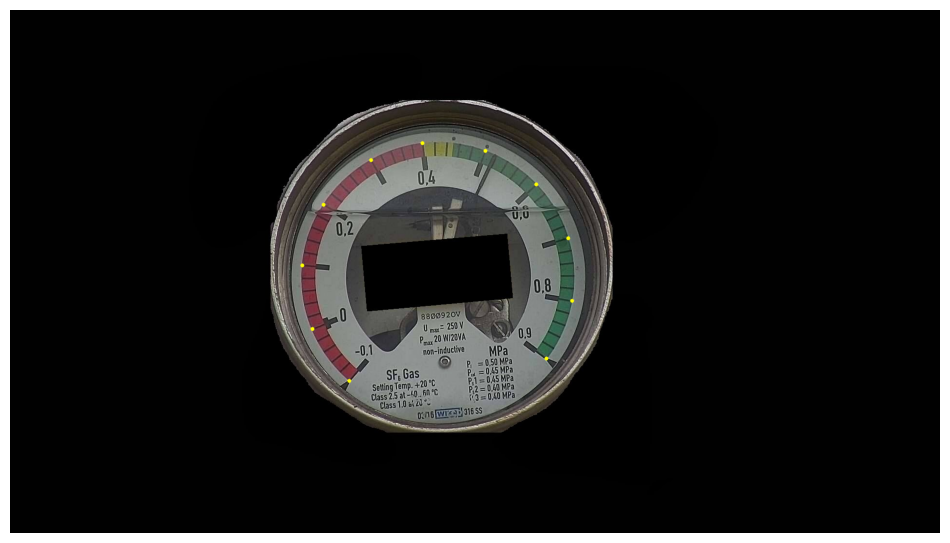

In [472]:
# 拟合过程前转换为直角坐标系（图像坐标系下的y是反的）
x_samples = candidate_point.T[0]
y_samples = image.shape[1] - candidate_point.T[1]
show_point(image, x_samples, y_samples)

In [473]:
# 求解a_res, b_res, x0, y0, alpha_res
a_res, b_res, x0, y0, alpha_res = fit_ellipse(x_samples, y_samples)

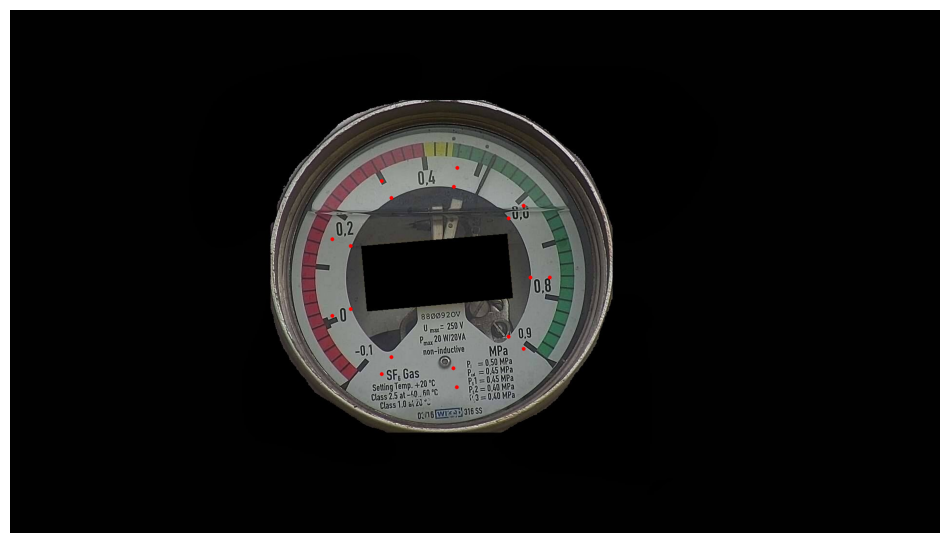

In [491]:
zone_point_x = zone_point[0]
zone_point_y = image.shape[1] - zone_point[1]

# 求出方向向量上在椭圆的坐标点
theta_zone_point_in_ellipse = np.arctan2(zone_point_y - y0, zone_point_x - x0)
point_in_ellipse_x, point_in_ellipse_y = Point_in_ellipse(x0, y0, a_res, b_res, alpha_res, theta_zone_point_in_ellipse)

zone_vec1 = np.array([zone_point_x, zone_point_y]) - np.array([x0,y0])
zone_vec2 = np.array([point_in_ellipse_x, point_in_ellipse_y]) - np.array([x0,y0])
s = np.linalg.norm(zone_vec1)/np.linalg.norm(zone_vec2) # 根据向量长度求出缩放因子
a_zone = a_res * s
b_zone = b_res * s

# 扫描区域 中线的椭圆
theta_res = np.linspace(0, 2*np.pi, 10)  # Angle values
x_zone, y_zone = Point_in_ellipse(x0, y0, a_zone, b_zone, alpha_res, theta_res)

# 扫描区域可视化
s_l = (np.linalg.norm(zone_vec1)-zone_radius)/np.linalg.norm(zone_vec2) # 根据向量长度求出缩放因子
s_r = (np.linalg.norm(zone_vec1)+zone_radius)/np.linalg.norm(zone_vec2) # 根据向量长度求出缩放因子
x_zone_l, y_zone_l = Point_in_ellipse(x0, y0, a_res * s_l, b_res * s_l, alpha_res, theta_res)
x_zone_r, y_zone_r = Point_in_ellipse(x0, y0, a_res * s_r, b_res * s_r, alpha_res, theta_res)

show_point(image, np.concatenate((x_zone_l, x_zone_r)), np.concatenate((y_zone_l, y_zone_r)), (0, 0, 255))

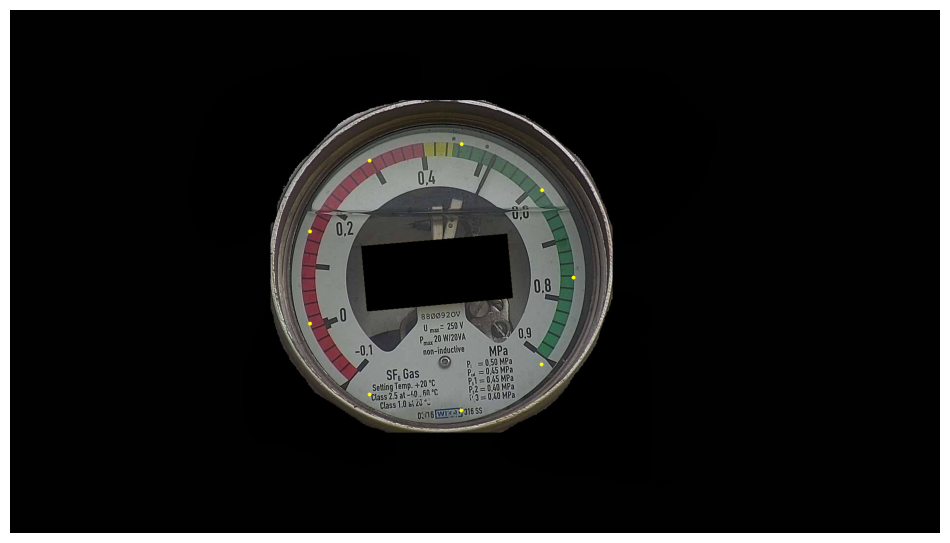

In [475]:
# debug

theta_res = np.linspace(0, 2*np.pi, 10)  # Angle values
x_res, y_res = Point_in_ellipse(x0, y0, a_res, b_res, alpha_res, theta_res)
# 预览 检查椭圆曲线拟合
show_point(image, x_res, y_res)


# 这里只显示椭圆形状 点准不准没有意义

In [476]:
def SIFT4H(img1, img2, debug):

    # 初始化SIFT检测器
    sift = cv2.SIFT_create()
    # 使用SIFT找到关键点和描述符
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # FLANN 参数设计
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)   # 或传递一个空字典

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # 准备计算单应性矩阵的数据
    good_matches = []
    pts1 = []
    pts2 = []

    # 应用比例测试
    for i, (m, n) in enumerate(matches):
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt)

    pts1 = np.float32(pts1).reshape(-1, 2)
    pts2 = np.float32(pts2).reshape(-1, 2)

    # 获取单应性矩阵
    H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, 5.0)

    # 绘制匹配结果
    draw_params = dict(matchColor=(0, 255, 0),  # 使用绿色绘制匹配项
                       singlePointColor=None,
                       matchesMask=mask.ravel().tolist(),  # 只绘制内部点
                       flags=2)


    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, **draw_params)

    if not debug: return H
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
    plt.title('Matches')
    plt.show()

    return H

In [477]:
# 将模板点的点集透视变化到目标图中
def transform_template(template_point, img1, img2, debug):

    # 求解单应
    H = SIFT4H(img1, img2, debug)
    if H is None: return None

    template_projected_points = cv2.perspectiveTransform(template_point.reshape(-1,1,2), H)
    return template_projected_points.reshape(-1,2)

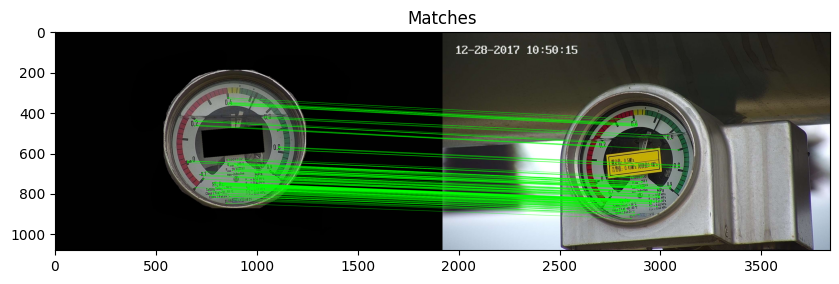

In [492]:
img1 = cv2.imread(image_path)
img2 = cv2.imread('source/1.1/img/tv20171228105011CF2FC4.jpg')

template_point = np.array([x_res, image.shape[1] - y_res]).T
template_projected_points = transform_template(template_point, img1, img2, True)

template_point_zone_l = np.array([x_zone_l, image.shape[1] - y_zone_l]).T
template_point_zone_r = np.array([x_zone_r, image.shape[1] - y_zone_r]).T

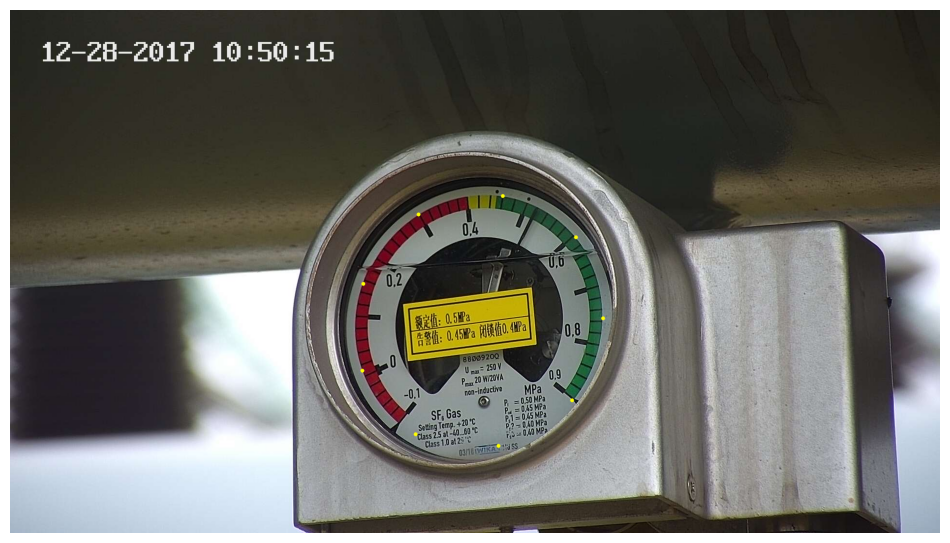

In [479]:
x_point = template_projected_points.T[0]
y_point = template_projected_points.T[1]

x_point_zone_l = template_point_zone_l.T[0]
y_point_zone_l = template_point_zone_l.T[1]

x_point_zone_r = template_point_zone_r.T[0]
y_point_zone_r = template_point_zone_r.T[1]


show_point(img2, x_point, y_point, reversed=False)

In [480]:
# 待测图像的椭圆方程
a_res2, b_res2, x02, y02, alpha_res2 = fit_ellipse(x_point, y_point)

a_res_zone_l, b_res_zone_l, x0_zone_l, y0_zone_l, alpha_res_zone_l = fit_ellipse(x_point_zone_l, y_point_zone_l)
a_res_zone_r, b_res_zone_r, x0_zone_r, y0_zone_r, alpha_res_zone_r = fit_ellipse(x_point_zone_r, y_point_zone_r)

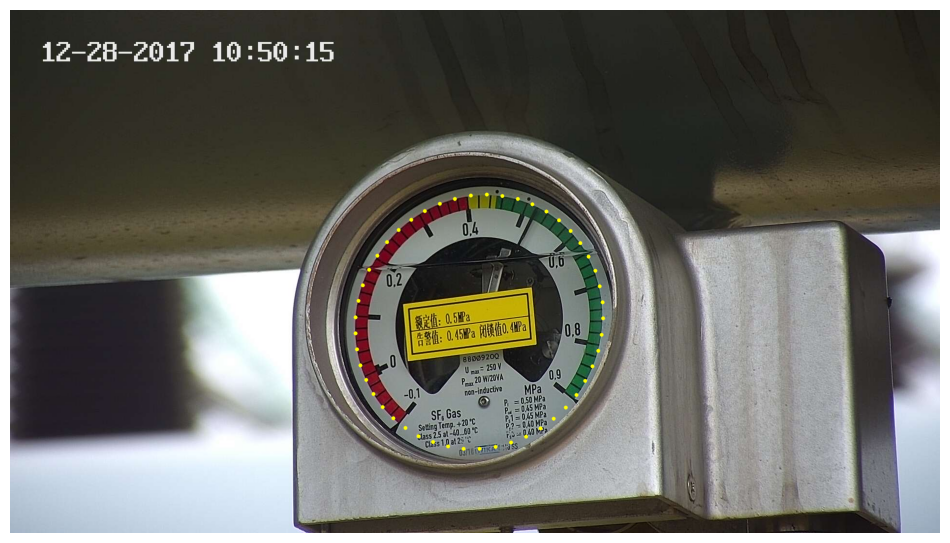

In [481]:
theta_res2 = np.linspace(0, 2*np.pi, 50)  # Angle values
x_res2, y_res2 = Point_in_ellipse(x02, y02, a_res2, b_res2, alpha_res2, theta_res2)
# 预览 检查椭圆曲线拟合
show_point(img2, x_res2, y_res2, reversed=False)

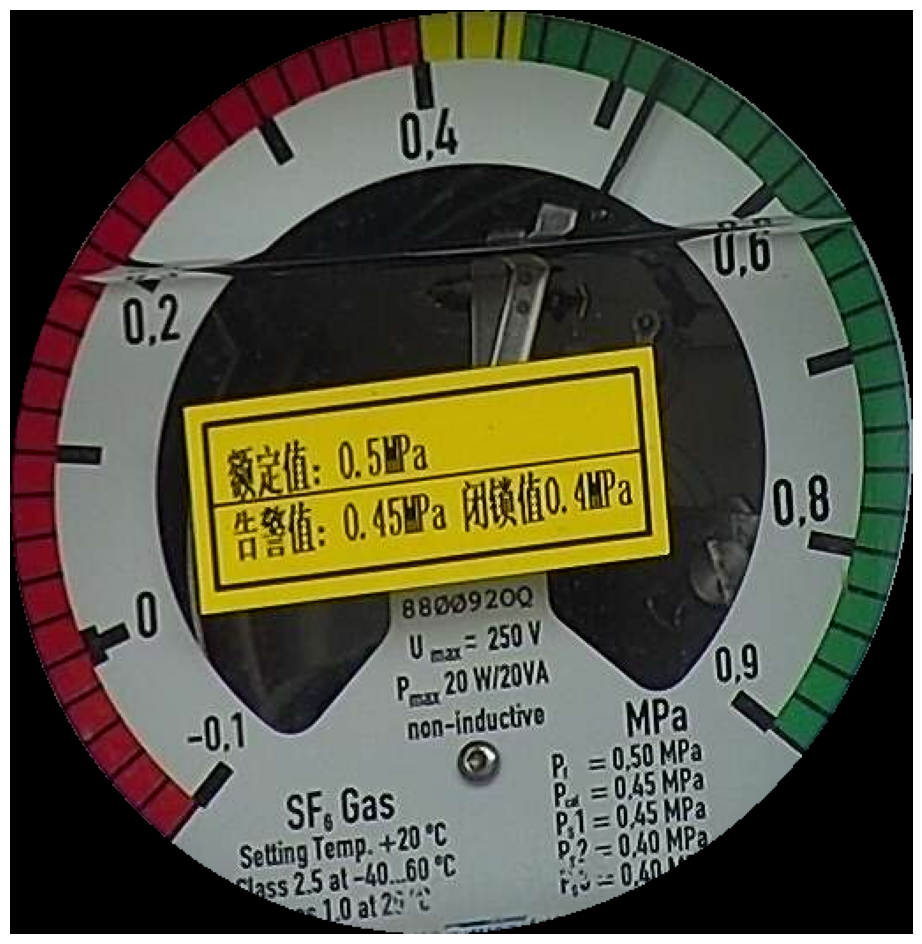

In [482]:
def mask_image_outside_ellipse_vectorized(img, a, b, x0, y0, alpha):
    # Create a copy of the image to avoid modifying the original
    img_masked = img.copy()

    # Generate meshgrid for efficient computation
    Y, X = np.ogrid[:img.shape[0], :img.shape[1]]
    cos_alpha = np.cos(alpha)
    sin_alpha = np.sin(alpha)

    # Compute rotated coordinates
    x_rot = (X - x0) * cos_alpha + (Y - y0) * sin_alpha
    y_rot = -(X - x0) * sin_alpha + (Y - y0) * cos_alpha

    # Compute the ellipse equation and create a mask
    ellipse_mask = ((x_rot ** 2) / (a ** 2)) + ((y_rot ** 2) / (b ** 2)) <= 1

    # Apply the mask to the image
    img_masked[~ellipse_mask] = [0, 0, 0]
    # Calculate the bounding box of the ellipse using the mask
    rows, cols = np.where(ellipse_mask)
    if len(rows) == 0 or len(cols) == 0:
        # If there are no points inside the ellipse, return an empty image
        return np.zeros((0, 0, img.shape[2]), dtype=img.dtype) if len(img.shape) == 3 else np.zeros((0, 0), dtype=img.dtype)

    top_left_x, top_left_y = max(0, np.min(cols)), max(0, np.min(rows))
    bottom_right_x, bottom_right_y = min(img.shape[1], np.max(cols) + 1), min(img.shape[0], np.max(rows) + 1)

    # Crop the masked image to the bounding box
    cropped_img = img_masked[top_left_y:bottom_right_y, top_left_x:bottom_right_x]
    return cropped_img


# Apply the mask using vectorized operation
img_masked_vectorized= mask_image_outside_ellipse_vectorized(img2, a_res2, b_res2, x02, y02, alpha_res2)
show_img(img_masked_vectorized)

In [483]:
gray_image = cv2.cvtColor(img_masked_vectorized, cv2.COLOR_BGR2GRAY)

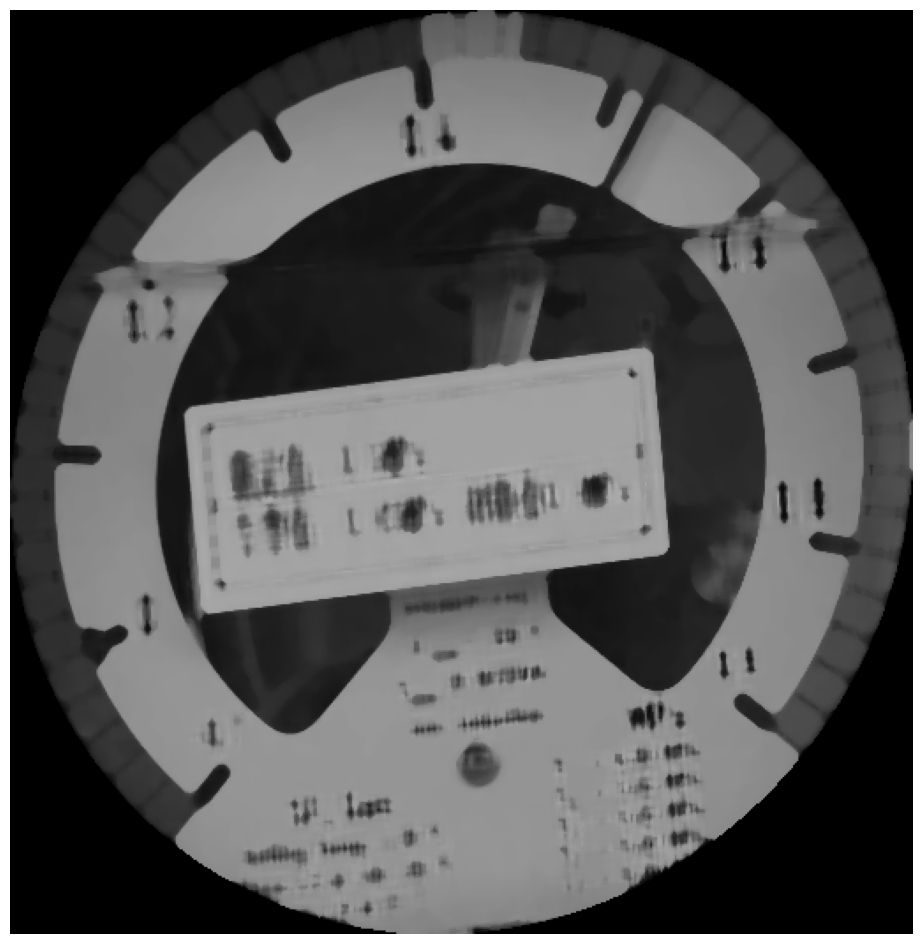

In [484]:
median_filtered_image = cv2.medianBlur(gray_image, ksize=9) # 这里ksize是窗口大小，必须是正奇数
show_img(median_filtered_image)

82.0


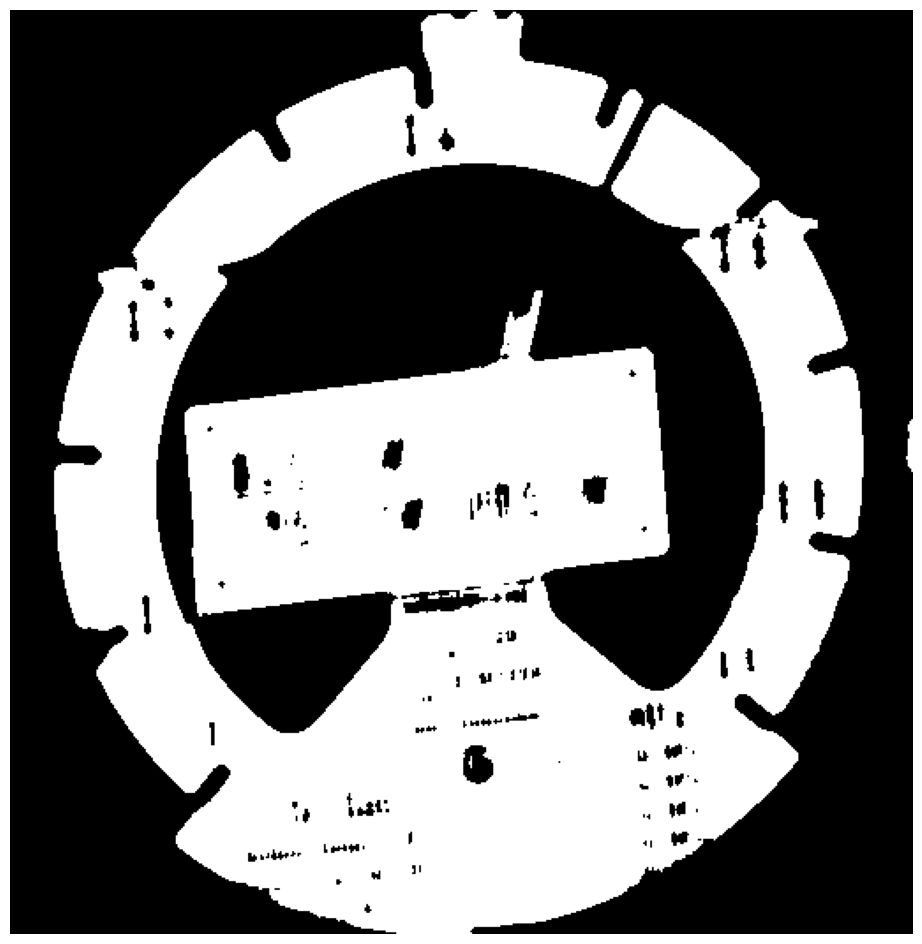

In [485]:
# Otsu's二值化方法 ret是二值化阈值
ret, binary_image = cv2.threshold(median_filtered_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print(ret)
show_img(binary_image)

In [486]:
def save_cv_image_with_plt(cv_image, output_path):
    # 如果图像是彩色的，则将其从BGR转换为RGB
    if len(cv_image.shape) == 3:
        rgb_image = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
    else:
        rgb_image = cv_image  # 灰度图像不需要转换

    # 创建一个新的图形，并关闭坐标轴
    plt.figure()
    plt.axis('off')  # 关闭坐标轴
    plt.gca().set_axis_off()  # 隐藏边框

    # 显示图像
    plt.imshow(rgb_image, cmap='gray' if len(cv_image.shape) == 2 else None)

    # 保存图像到文件，bbox_inches='tight' 和 pad_inches=0 用来去掉边缘空白
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0, dpi=300)
    plt.close()  # 关闭当前图形以释放内存

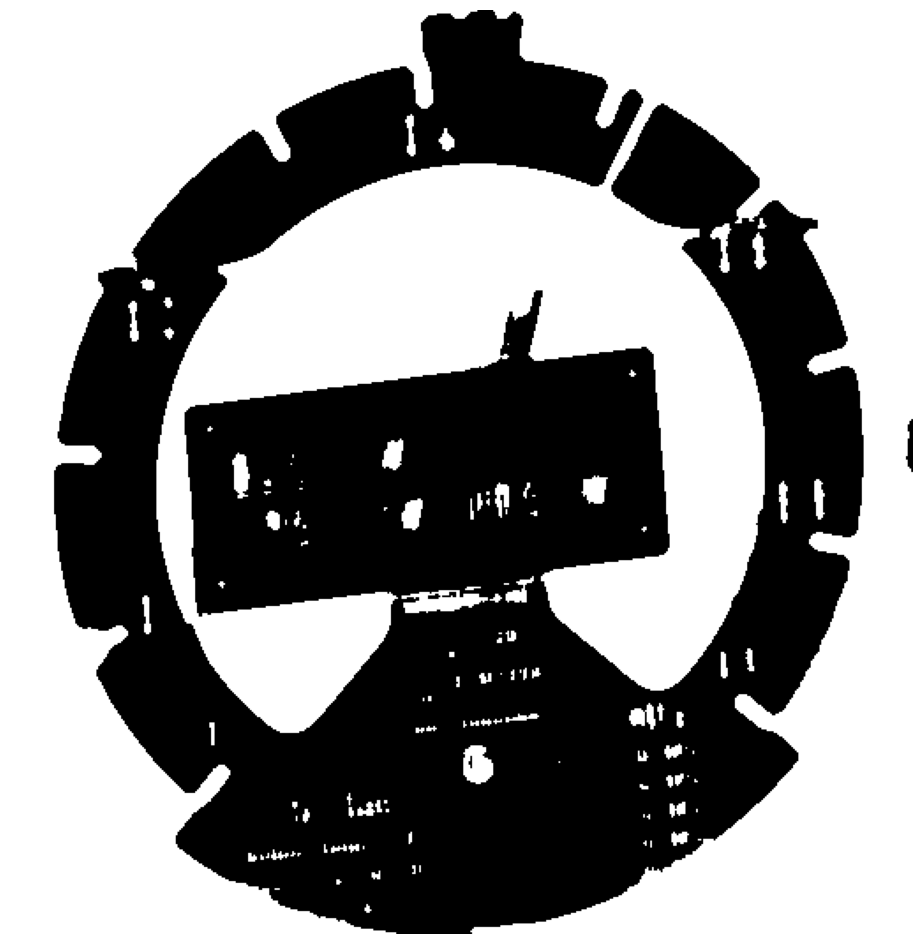

In [487]:
# 反转
inverted_image = 255 - binary_image.copy()
show_img(inverted_image)

In [488]:
def process_pointer_image(binary_image):
    # 定义结构元素（内核），用于形态学操作
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))  # 调整内核大小

    # 膨胀操作 - 连接间断点
    dilated_image = cv2.dilate(binary_image.copy(), kernel, iterations=1)  # 增加膨胀迭代次数

    # 腐蚀操作 - 恢复指针原始宽度
    eroded_image = dilated_image.copy()
    previous = None
    while not np.array_equal(eroded_image, previous):  # 使用np.array_equal进行比较
        previous = eroded_image.copy()  # 确保使用深拷贝
        eroded_image = cv2.erode(eroded_image, kernel, iterations=1)
    return dilated_image

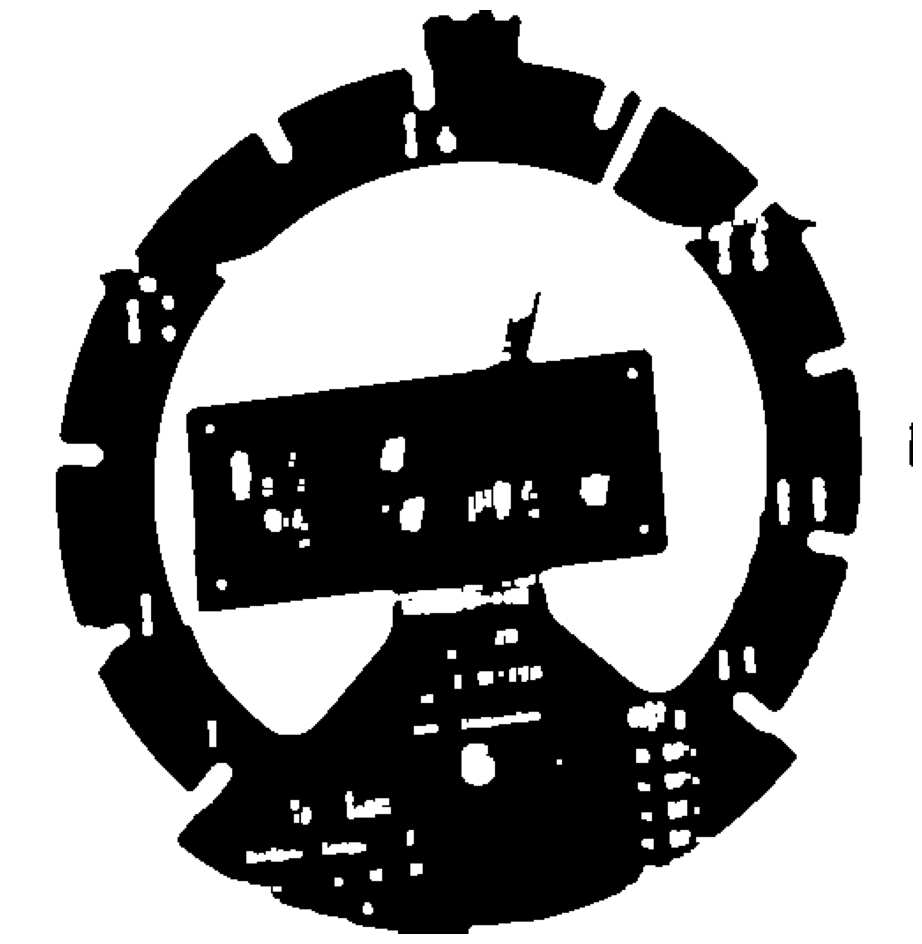

In [489]:
processed_image = process_pointer_image(inverted_image)
show_img(processed_image)

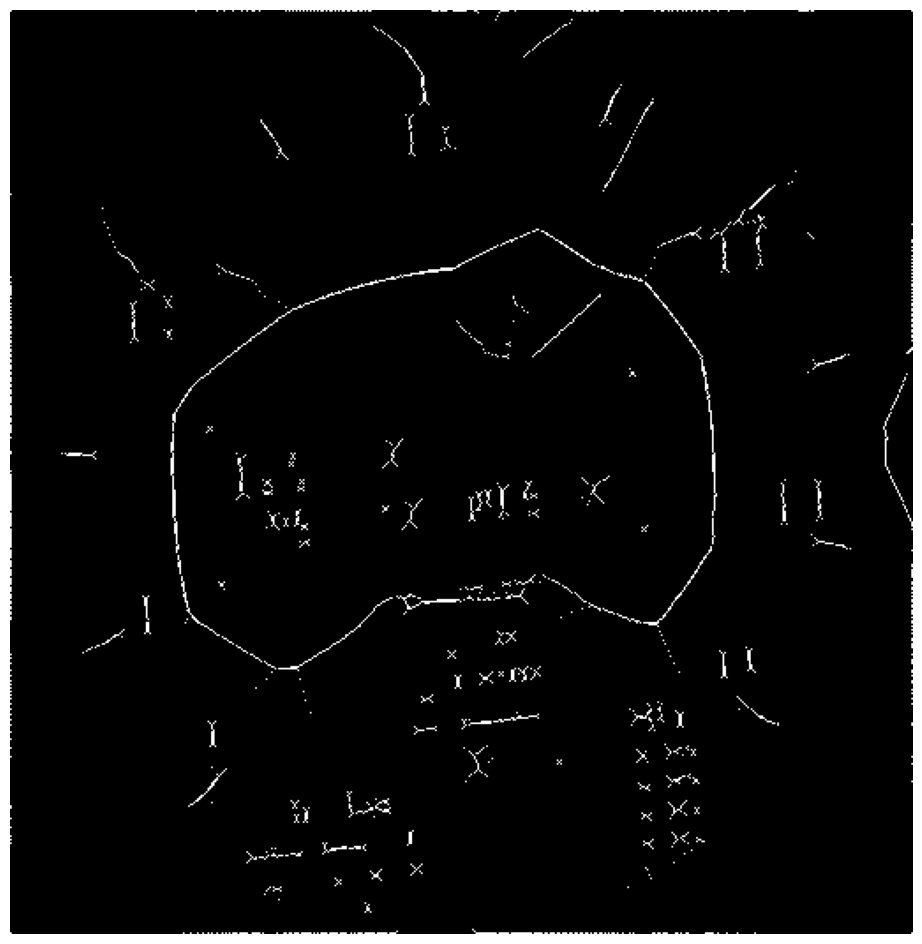

In [490]:
# 细化操作 - 将指针细化为直线段
def thinning(src_img):

    src = src_img.copy()
    size = np.size(src)
    skel = np.zeros(src.shape, np.uint8)
    element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    done = False

    while not done:
        eroded = cv2.erode(src, element)
        temp = cv2.dilate(eroded, element)
        temp = cv2.subtract(src, temp)
        skel = cv2.bitwise_or(skel, temp)
        src = eroded.copy()
        zeros = size - cv2.countNonZero(src)
        if zeros == size:
            done = True
    return skel

thinning_img = thinning(processed_image)
show_img(thinning_img)